# News Classification with Pegasos

Let's import the required libraries. We also use the `imbalanced-learn` library, that can be installed by executing the following command in the terminal:

    conda install -c conda-forge imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import timeit

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.base import BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve, learning_curve

from IPython.display import display

## Data pre-processing

Read the dataset file and create a list where each element corresponds to a line of the file (that is, to a document news)

In [2]:
news = []
with open("SingerSplit_sorted_20k.data", "r") as file:
    news = file.readlines()

Initialize dictionaries and lists

In [3]:
labelsFreq, toRemove, y = {}, [], []

Let's iterate through each news. Create the list of dictionaries that will contain the features and the list of labels.
Remember that the format of each line is:

    docId labList = feature:val feature:val feature:val ...
    
What we do is the following:
    1. Iterate through each line
    2. Remove the characters '\n' at the end of each line
    3. Remove the part of the 'docId', that we can identify by removing all the characters before the very first space charcater
    4. Find the position of the equal sign in order to split labels and features
    5. If a row does not have labels, add its position to the list containing the indexes to be removed and skip it.
    6. Otherwise, get the labels. They are all characters before the equal sign.
    7. Split the string of labels into a list and append them to the labels list
    8. Update the frequency count of each label. This means looking into the dictionary that has the label as key and the times it appears as value. If the label is present, add +1 to the count. Otherwise, add the new label and assign value 1.
    9. Get the features. They are all the characters after the equal sign.
    10. Split the string of features first by each space sign, in order to get a list of strings like 'feature:value'.
    11. Then split each element of the list again by the ':' sign, and add it to the dictionary of the features.

In [4]:
for i in range(0,len(news)):
    # We need this to treat the row as a string
    s = news[i]
    
    # Remove trailing '\n'
    s = s.replace("\n", "") 
    
    # Remove doc000000 
    s = s[s.find(" ") + 1:] 
    
    # Find the position of the '=' sign
    ind = s.find("=")
    
    # Some rows do not have labels. We'll skip them
    # and later remove them
    if ind == 0:
        toRemove.append(i)
    else:
        # Get the labels
        lbl = s[:ind - 1]
        lblList = lbl.split(" ")
        lblList = [np.int32(x) for x in lblList]
        y.append(lblList)
        
        # Update the labels frequency count
        for key in lblList:
            if key in labelsFreq:
                labelsFreq[key] += 1
            else:
                labelsFreq[key] = 1
        
        # Get the features
        feats = s[ind+2:]
        featsList1 = feats.split(" ")
        finalFeat = {}
        for x in featsList1:
            elem = x.split(":")
            a = elem[0]
            b = elem[1]
            d = {a: b}
            finalFeat.update(d)
                
        news[i] = finalFeat

Remove the rows with no label. The `reverse` param is needed to avoid a nasty problem.

In [5]:
[news.pop(i) for i in sorted(toRemove, reverse=True)]
news[0]

{'372': '0.0322298670393407',
 '412': '0.0399666607009284',
 '1191': '0.0208579883334745',
 '1398': '0.03469461250916',
 '1696': '0.0313742944440639',
 '1788': '0.101860242861076',
 '1946': '0.0482992561844891',
 '2007': '0.0608106298756862',
 '2051': '0.0685800346592637',
 '2118': '0.0460935142795857',
 '2357': '0.064574545251984',
 '2358': '0.0679112351082636',
 '3010': '0.0302992811495597',
 '3223': '0.0535774602927466',
 '3332': '0.0528445944684083',
 '3525': '0.124761568327326',
 '3678': '0.114124916097942',
 '3821': '0.0374500120062826',
 '3943': '0.0491044772013921',
 '4582': '0.0423139885170287',
 '4660': '0.0338201197562019',
 '4754': '0.0905414297162012',
 '5065': '0.0546179961978313',
 '5152': '0.0379625776601642',
 '5371': '0.0563250723470629',
 '5747': '0.114623751792671',
 '6292': '0.0515429194037677',
 '6391': '0.0653704764924526',
 '6392': '0.0915777427420058',
 '6539': '0.0333395456778519',
 '6896': '0.0485553861036169',
 '6926': '0.00535893643734539',
 '7096': '0.0496

Let's get the 4 most present labels. Dict comprehension taken from: https://stackoverflow.com/a/40777805

In [6]:
highest = list(({key: labelsFreq[key] for key in sorted(labelsFreq, key=labelsFreq.get, reverse=True)[:4]}).keys())
highest

[33, 70, 101, 4]

Create the 4 list containing the labels:
- 1 if the element contains the most frequent label
- 0 otherwise

In [7]:
y1, y2, y3, y4 = [], [], [], []

for i in range(1, 5):
    for row in y:
        if highest[i-1] in row:
            eval('y'+str(i)).append(int(1))
        else:
            eval('y'+str(i)).append(int(-1))
            
y1 = np.asarray(y1)
y2 = np.asarray(y2)
y3 = np.asarray(y3)
y4 = np.asarray(y4)

Check the distribution of the labels

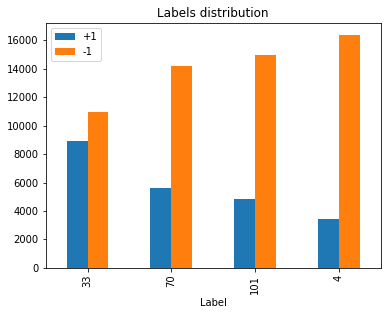

In [8]:
pos, neg = [], []
for i in range(1,5):
    index, count = np.unique(eval('y'+str(i)), return_counts=True)
    pos.append(np.int32(count[1]))
    neg.append(np.int32(count[0]))

df = pd.DataFrame(np.column_stack([highest, pos, neg]), columns=['Label','+1','-1'])
fig = df.plot(x="Label", y=["+1", "-1"], kind="bar", title='Labels distribution', figsize=(6, 4.5)).get_figure()
fig.savefig("label_distribution.png")

In [9]:
df

,Label,+1,-1
0,33,8899,10961
1,70,5634,14226
2,101,4874,14986
3,4,3465,16395


We can clearly see that we are dealing with inbalanced classes, except for the first label. Thus, we'll use _F1_ as our main metric. We'll also check other metrics just to be sure for comparison. Moreover, we'll upsample and downsample to see if this helps the classifier

The **F1 score** can be interpreted as a weighted average of the precision and recall:

$$F1 = 2 \cdot \frac{(precision \cdot recall)}{(precision + recall)} $$

where **precision** can be seen as "the ability of the classifier not to label as positive a sample that is negative":

$$ precision=\frac{true\ positive}{true\ postive + false\ positive} $$

and **recall** can be seen as "the ability of the classifier to find all the positive samples":

$$ recall=\frac{true\ positive}{true\ postive + false\ negative} $$

We'll deal with this while implementing the `MyBaseClassifier` from which both `Pegasos` and the `Perceptron` will inherit.

Let's do the last steps of our data pre-processing. Convert features to `int` and values to `float`. Dict comprehension taken from: https://stackoverflow.com/a/5317657

In [10]:
news = [dict([int(a), float(x)] for a, x in elem.items()) for elem in news]

Transforms lists of feature-value mappings to a CSR matrix. Setting the `dtype` param to `np.float32` cuts memory usage by 50%!

In [11]:
v = DictVectorizer(sparse=True, dtype=np.float32)
X = v.fit_transform(news)
X

<19860x80362 sparse matrix of type '<class 'numpy.float32'>'
	with 1858673 stored elements in Compressed Sparse Row format>

Since our data is very sparse, using a CSR matrix instead of a dense one (or a classical Pandas DataFrame) allows us to save a lot of memory, as we can see below.

**Warning**: the execution of this cell requires more than 6GB of memory (either RAM or swap). If you don't have them, you can simply skip this cell.

In [12]:
dense_size = np.round(np.array(X.toarray()).nbytes/1e6, 2)
sparse_size = np.round((X.data.nbytes + X.indptr.nbytes + X.indices.nbytes)/1e6, 2)

print("Dense: ", dense_size, "MB")
print("Sparse: ", sparse_size, "MB")

Dense:  6383.96 MB
Sparse:  14.95 MB


Free up some memory

In [12]:
del news
del toRemove
del labelsFreq

## Pegasos

Here there's our own Pegasos implementation. It inherits from the `BaseEstimator` so that we don't need to define the `get_params` and `set_params` methods. Moreover, we created a class `MyBaseClassifier` that contains the `predict` and `score` methods. Both our Pegagos and Perceptron implementations will inherit from this class so that, in the end, we can use them in the `GridSearchCV`. 

In [13]:
class MyBaseClassifier():
    def sign(self, X):
        return -1. if X <= 0 else 1.
    
    def predict(self, X):
        pred = X.dot(self.w.T)
        return [self.sign(pred[i]) for i in range(len(pred))]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

In [14]:
class Pegasos(BaseEstimator, MyBaseClassifier):
    def __init__(self, lmbd=0.001, T=1000):
        self.T = T
        self.lmbd = lmbd
        
    def fit(self, X, y):
        # Initialize w vector to zero
        self.w = np.zeros(X.shape[1])
    
        for t in range(1, self.T + 1):
            # We pick a random position i in the training set.
            i = np.random.randint(0, X.shape[0]-1)

            # Step length in gradient descent
            eta = 1/(self.lmbd*t)

            # Compute the score, that is the inner product
            # between w and the current training example
            score = X[i].dot(self.w.T)

            # Check if we got it right
            if y[i]*score < 1:
                self.w = (1 - eta*self.lmbd)*self.w + (eta*y[i])*X[i]
            else:
                self.w = (1 - eta*self.lmbd)*self.w

### Label 1: 33

Since we have to train 4 classifiers for the 4 most frequent labels, create this variable where we set what label we're training our classifier to recognize.

In [15]:
currentLabel = y1

Let's now get a first training/test split, where we allocate a third of the dataset as test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,currentLabel,test_size=0.33,random_state=42,stratify=currentLabel)

Run Pegasos for the first time. We use the default values for `lmbd=0.001` and `T=1000` that we set in our implementation.

In [18]:
classifier = Pegasos()

In [19]:
classifier.fit(X_train, y_train)

In [20]:
classifier.score(X_train, y_train), classifier.score(X_test, y_test)

(0.8711993617587093, 0.8516624040920716)

We now check other metrics:

In [21]:
TPs, FPs, TNs, FNs, precisions, recalls, accs = [], [], [], [], [], [], []
y_pred = classifier.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
    
TNs.append(tn)
TPs.append(tp)
FPs.append(fp)
FNs.append(fn)
precisions.append(precision)
recalls.append(recall)
accs.append(acc)
    
print("True positive: ", tp)
print("False positive: ", fp)
print("FP ratio: ", fp/(tp+fp),"(",np.round(fp/(tp+fp)*100, 2),"%)")
print("True negative: ", tn)
print("False negative: ", fn)
print("FN ratio: ", fn/(tn+fn),"(",np.round(fn/(tn+fn)*100, 2),"%)")
print("Precision: ", precision,"(",np.round(precision*100, 2),"%)")
print("Recall: ", recall,"(",np.round(recall*100, 2),"%)")
print("Accuracy: ", acc,"(",np.round(acc*100, 2),"%)")

True positive:  2331
False positive:  206
FP ratio:  0.08119826566811195 ( 8.12 %)
True negative:  3411
False negative:  606
FN ratio:  0.1508588498879761 ( 15.09 %)
Precision:  0.918801734331888 ( 91.88 %)
Recall:  0.7936670071501533 ( 79.37 %)
Accuracy:  0.8761061946902655 ( 87.61 %)


Pegasos doesn't always deliver the same results because it depends on the order of which the training examples are presented. Therefore, we run it 100 times and we average the results.

In [22]:
results_train, results_test = [], []
for i in range(100):
    classifier.fit(X_train, y_train)
    results_train.append(classifier.score(X_train, y_train))
    results_test.append(classifier.score(X_test, y_test))

np.mean(results_train), np.mean(results_test)

(0.8768452910151163, 0.8654436843812745)

We don't want to stick to a single split. Let's see the learning curve. We use a 10-fold cross validation because we read a paper that suggests so :)

In [23]:
sizes = range(1000, 14000, 1000)
train_size, train_score, val_score = learning_curve(Pegasos(), X, currentLabel, train_sizes=sizes, cv=10,
                                                   n_jobs=-1, verbose=10)
val_score

[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    2.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    5.0s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:    7.3s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:    9.2s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:   11.5s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   13.9s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   16.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   18.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   20.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   22.2s finished


array([[0.82259887, 0.82635399, 0.84102564, 0.83686319, 0.83544304,
        0.81397006, 0.82045322, 0.82388359, 0.76092233, 0.81333333],
       [0.82436428, 0.84130688, 0.8658726 , 0.8730065 , 0.88998156,
        0.82094082, 0.84533648, 0.86915888, 0.83473054, 0.83949045],
       [0.84270953, 0.85431235, 0.86015831, 0.84441733, 0.88847584,
        0.83370619, 0.85697875, 0.86197779, 0.83610451, 0.82490272],
       [0.84982538, 0.83775811, 0.89406994, 0.85645356, 0.89783654,
        0.82281369, 0.84542212, 0.86475196, 0.85681293, 0.85215221],
       [0.87185104, 0.86021505, 0.86515071, 0.87478754, 0.89444783,
        0.8324568 , 0.87681971, 0.85287846, 0.88690808, 0.82398957],
       [0.84324324, 0.85859729, 0.87098473, 0.85495283, 0.89663462,
        0.82370593, 0.87023744, 0.87018984, 0.87364208, 0.83967561],
       [0.85454545, 0.86157381, 0.87247609, 0.85765125, 0.89263421,
        0.82809071, 0.88403361, 0.86446886, 0.85913043, 0.86112796],
       [0.85447107, 0.84540787, 0.8664529

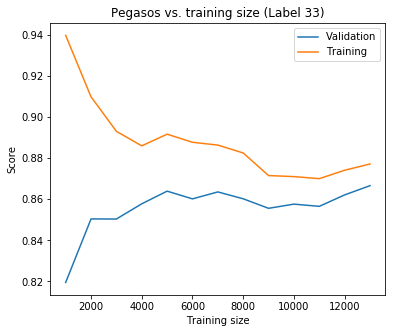

In [25]:
plt.figure(figsize=(6, 5))
plt.title('Pegasos vs. training size (Label 33)')
plt.plot(train_size, np.mean(val_score, 1), label='Validation')
plt.plot(train_size, np.mean(train_score, 1), label='Training')
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Score')

plt.savefig('pegasos_learning_curve_y1.png')
plt.show()

We now want to check what are the best values for `lmbd` and `T`. Therefore, we use `GridSearchCV` to estimate them. Again, we run a 10-fold cross validation.

In [26]:
params = []
param_grid = [{'T':[10,100,1000,2000,5000,10000,X.shape[0]],
               'lmbd': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}]

svc = Pegasos()
clf = GridSearchCV(svc, param_grid, cv = 10, verbose=10, n_jobs=-1)

clf.fit(X, currentLabel)

params.append([clf.best_params_, clf.best_score_])
params[0]

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[{'T': 19860, 'lmbd': 0.0001}, 0.9119869516392145]

### Other labels: 70, 101, 4

We now repeat the same workflow for the other labels.
However, here we also upsample and undersample data in order to check if the algorithm prediction improves.

In [27]:
lbl_idx = { '2': '70', '3': '101', '4': '4' }
TPs_resampled, FPs_resampled, TNs_resampled, FNs_resampled, precisions_resampled, recalls_resampled, accs_resampled = [], [], [], [], [], [], []
TPs_unders, FPs_unders, TNs_unders, FNs_unders, precisions_unders, recalls_unders, accs_unders = [], [], [], [], [], [], []

for i in range(2,5):
    currentLabel = eval('y'+str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(X, currentLabel, test_size=0.33,
                                                        random_state=42, stratify=currentLabel)
    
    classifier = Pegasos()
    classifier.fit(X_train, y_train)
    train_score = classifier.score(X_train, y_train)
    
    y_pred = classifier.predict(X_test)  
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    TNs.append(tn)
    TPs.append(tp)
    FPs.append(fp)
    FNs.append(fn)
    precisions.append(precision)
    recalls.append(recall)
    accs.append(acc)
    
    # Up-sample
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    classifier = Pegasos()
    classifier.fit(X_train_resampled, y_train_resampled)
    train_score_resampled = classifier.score(X_train_resampled, y_train_resampled)
    
    y_pred = classifier.predict(X_test)  
    f1_resampled = f1_score(y_test, y_pred)
    tn_resampled, fp_resampled, fn_resampled, tp_resampled = confusion_matrix(y_test, y_pred).ravel()
    precision_resampled = precision_score(y_test, y_pred)
    recall_resampled = recall_score(y_test, y_pred)
    acc_resampled = accuracy_score(y_test, y_pred)
    
    TNs_resampled.append(tn_resampled)
    TPs_resampled.append(tp_resampled)
    FPs_resampled.append(fp_resampled)
    FNs_resampled.append(fn_resampled)
    precisions_resampled.append(precision_resampled)
    recalls_resampled.append(recall_resampled)
    accs_resampled.append(acc_resampled)
    
    # Under-sample
    rus = RandomUnderSampler(random_state=42, replacement=True)
    X_train_unders, y_train_unders = rus.fit_resample(X_train, y_train)
    
    classifier = Pegasos()
    classifier.fit(X_train_unders, y_train_unders)
    train_score_unders = classifier.score(X_train_unders, y_train_unders)
    
    y_pred = classifier.predict(X_test)  
    f1_unders = f1_score(y_test, y_pred)
    tn_unders, fp_unders, fn_unders, tp_unders = confusion_matrix(y_test, y_pred).ravel()
    precision_unders = precision_score(y_test, y_pred)
    recall_unders = recall_score(y_test, y_pred)
    acc_unders = accuracy_score(y_test, y_pred)
    
    TNs_unders.append(tn_unders)
    TPs_unders.append(tp_unders)
    FPs_unders.append(fp_unders)
    FNs_unders.append(fn_unders)
    precisions_unders.append(precision_unders)
    recalls_unders.append(recall_unders)
    accs_unders.append(acc_unders)
    
    print("\nLABEL ", lbl_idx.get(str(i)))
    print("==============")
    
    metrics_name = ["True positive", "False positive", "True negative", "False negative", "FP ratio", "FN ratio",
                    "Training score", "Test score", "Precision", "Recall", "Accuracy"]
    nr = [tp,fp,tn,fn,
          str(fp/(tp+fp))+" ("+str(np.round(fp/(tp+fp)*100, 2))+"%)",
          str(fn/(tn+fn))+" ("+str(np.round(fn/(tn+fn)*100, 2))+"%)",
          str(train_score)+" ("+str(np.round(train_score*100, 2))+"%)",
          str(f1)+" ("+str(np.round(f1*100, 2))+"%)",
          str(precision)+" ("+str(np.round(precision*100, 2))+"%)",
          str(recall)+" ("+str(np.round(recall*100, 2))+"%)",
          str(acc)+" ("+str(np.round(acc*100, 2))+"%)"]
    
    ovs = [tp_resampled,fp_resampled, tn_resampled,fn_resampled,
          str(fp_resampled/(tp_resampled+fp_resampled))+" ("+str(np.round(fp_resampled/(tp_resampled+fp_resampled)*100, 2))+"%)",
          str(fn_resampled/(tn_resampled+fn_resampled))+" ("+str(np.round(fn_resampled/(tn_resampled+fn_resampled)*100, 2))+"%)",
          str(train_score_resampled)+" ("+str(np.round(train_score_resampled*100, 2))+"%)",
          str(f1_resampled)+" ("+str(np.round(f1_resampled*100, 2))+"%)",
          str(precision_resampled)+" ("+str(np.round(precision_resampled*100, 2))+"%)",
          str(recall_resampled)+" ("+str(np.round(recall*100, 2))+"%)",
          str(acc_resampled)+" ("+str(np.round(acc_resampled*100, 2))+"%)"]
    
    uds = [tp_unders,fp_unders, tn_unders,fn_unders,
          str(fp_unders/(tp_unders+fp_unders))+" ("+str(np.round(fp_unders/(tp_unders+fp_unders)*100, 2))+"%)",
          str(fn_unders/(tn_unders+fn_unders))+" ("+str(np.round(fn_unders/(tn_unders+fn_unders)*100, 2))+"%)",
          str(train_score_unders)+" ("+str(np.round(train_score_unders*100, 2))+"%)",
          str(f1_unders)+" ("+str(np.round(f1_unders*100, 2))+"%)",
          str(precision_unders)+" ("+str(np.round(precision_unders*100, 2))+"%)",
          str(recall_unders)+" ("+str(np.round(recall*100, 2))+"%)",
          str(acc_unders)+" ("+str(np.round(acc_unders*100, 2))+"%)"]
    
    df1 = pd.DataFrame(np.column_stack([metrics_name, nr, ovs, uds]), columns=["Metric", "Not resampled", "Oversampled", "Undersampled"])
    display(df1)


LABEL  70


,Metric,Not resampled,Oversampled,Undersampled
0,True positive,1406,1733,1727
1,False positive,55,342,360
2,True negative,4640,4353,4335
3,False negative,453,126,132
4,FP ratio,0.03764544832306639 (3.76%),0.16481927710843375 (16.48%),0.17249640632486823 (17.25%)
5,FN ratio,0.08894561162379737 (8.89%),0.02813127930341594 (2.81%),0.029550033579583614 (2.96%)
6,Training score,0.861642625846335 (86.16%),0.938092991560518 (93.81%),0.9330859944348748 (93.31%)
7,Test score,0.846987951807229 (84.7%),0.8810371123538384 (88.1%),0.8753167764825139 (87.53%)
8,Precision,0.9623545516769336 (96.24%),0.8351807228915663 (83.52%),0.8275035936751318 (82.75%)
9,Recall,0.7563206024744487 (75.63%),0.9322216245293168 (75.63%),0.9289940828402367 (75.63%)



LABEL  101


,Metric,Not resampled,Oversampled,Undersampled
0,True positive,1116,1496,1511
1,False positive,86,318,371
2,True negative,4860,4628,4575
3,False negative,492,112,97
4,FP ratio,0.07154742096505824 (7.15%),0.175303197353914 (17.53%),0.1971307120085016 (19.71%)
5,FN ratio,0.09192825112107623 (9.19%),0.02362869198312236 (2.36%),0.020761986301369863 (2.08%)
6,Training score,0.808414464534075 (80.84%),0.942035464163314 (94.2%),0.9410334346504559 (94.1%)
7,Test score,0.794306049822064 (79.43%),0.8743424897720632 (87.43%),0.8659025787965616 (86.59%)
8,Precision,0.9284525790349417 (92.85%),0.824696802646086 (82.47%),0.8028692879914984 (80.29%)
9,Recall,0.6940298507462687 (69.4%),0.9303482587064676 (69.4%),0.9396766169154229 (69.4%)



LABEL  4


,Metric,Not resampled,Oversampled,Undersampled
0,True positive,821,1018,1041
1,False positive,66,186,313
2,True negative,5345,5225,5098
3,False negative,322,125,102
4,FP ratio,0.07440811724915446 (7.44%),0.15448504983388706 (15.45%),0.2311669128508124 (23.12%)
5,FN ratio,0.056820187047820714 (5.68%),0.02336448598130841 (2.34%),0.019615384615384614 (1.96%)
6,Training score,0.8309178743961352 (83.09%),0.9359837957510952 (93.6%),0.9328358208955225 (93.28%)
7,Test score,0.8088669950738916 (80.89%),0.8674904132935664 (86.75%),0.8338005606728074 (83.38%)
8,Precision,0.9255918827508456 (92.56%),0.845514950166113 (84.55%),0.7688330871491876 (76.88%)
9,Recall,0.7182852143482065 (71.83%),0.8906386701662292 (71.83%),0.910761154855643 (71.83%)


[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.3s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    3.8s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:    6.1s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:    8.1s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:   10.4s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   12.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   14.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   16.8s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   18.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.3s remaining:   33.1s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    3.6s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:    5.8s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:    7.4s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:    9.6s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   11.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   13.7s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   15.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   17.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.2s remaining:   30.1s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    3.5s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:    5.4s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:    7.0s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:    9.2s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   11.1s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   12.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   14.8s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   16.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   18.0s finished


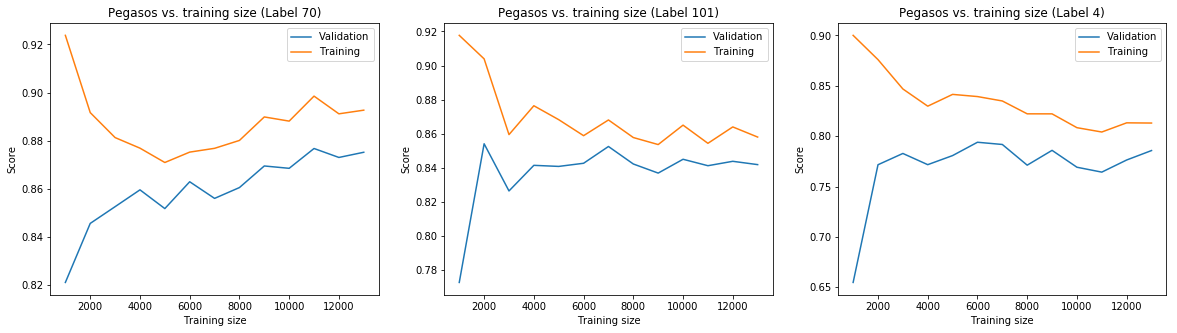

In [28]:
plt.figure(figsize=(20, 5))

for i in range(2,5):
    currentLabel = eval('y'+str(i))

    sizes = range(1000, 14000, 1000)
    train_size, train_score, val_score = learning_curve(Pegasos(), X, currentLabel, train_sizes=sizes, cv=10,
                                                   n_jobs=-1, verbose=10)
    
    plt.subplot(1, 3, i-1)
    plt.title('Pegasos vs. training size (Label ' + lbl_idx.get(str(i)) + ')')
    plt.plot(train_size, np.mean(val_score, 1), label='Validation')
    plt.plot(train_size, np.mean(train_score, 1), label='Training')
    plt.legend()
    plt.xlabel('Training size')
    plt.ylabel('Score')

plt.savefig('pegasos_learning_curve_other.png')
plt.show()

We run `GridSearchCV` to get the best parameters of Pegasos for every label.

In [29]:
for i in range(2,5):
    currentLabel = eval('y'+str(i))
    
    param_grid = [{'T':[10,100,1000,2000,5000,10000,X.shape[0]],
               'lmbd': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}]

    svc = Pegasos()
    clf = GridSearchCV(svc, param_grid, cv = 10, verbose=10, n_jobs=-1)

    clf.fit(X, currentLabel)

    params.append([clf.best_params_, clf.best_score_])

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Results: Pegasos

We now analyze the results.

#### No resampling

These are for the random split where the test set is a third of the dataset, with no resampling.

In [30]:
df_metrics = pd.DataFrame(np.column_stack([highest, TPs, FPs, TNs, FNs, precisions, recalls, accs]),
                  columns=['Label',
                           'True Positive',
                           'False Positive',
                           'True Negative', 
                           'False Negative',
                           'Precision',
                           'Recall',
                           'Accuracy'])

df_metrics = df_metrics.astype({'Label': int,
                                'True Positive': int,
                                'False Positive': int,
                                'True Negative': int,
                                'False Negative': int})
df_metrics

,Label,True Positive,False Positive,True Negative,False Negative,Precision,Recall,Accuracy
0,33,2331,206,3411,606,0.918802,0.793667,0.876106
1,70,1406,55,4640,453,0.962355,0.756321,0.922490
2,101,1116,86,4860,492,0.928453,0.694030,0.911810
3,4,821,66,5345,322,0.925592,0.718285,0.940800


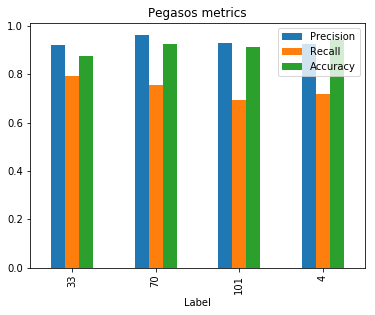

In [31]:
fig = df_metrics.plot(x='Label', 
                      y=['Precision', 'Recall', 'Accuracy'],
                      kind="bar",
                      title='Pegasos metrics',
                      figsize=(6, 4.5)).get_figure()

fig.savefig("pegasos_all_metrics.png")

In [32]:
print("Mean Precision: ", df_metrics["Precision"].mean())
print("Mean Recall: ", df_metrics["Recall"].mean())
print("Mean Accuracy: ", df_metrics["Accuracy"].mean())

Mean Precision:  0.9338001869486523
Mean Recall:  0.7405756686797693
Mean Accuracy:  0.912801342691486


#### Upsampling

These are for the random split where the test set is a third of the dataset, with upsampling.

In [33]:
df_metrics_resampled = pd.DataFrame(np.column_stack([highest[1:], TPs_resampled, FPs_resampled, TNs_resampled, FNs_resampled, precisions_resampled, recalls_resampled, accs_resampled]),
                  columns=['Label',
                           'True Positive',
                           'False Positive',
                           'True Negative', 
                           'False Negative',
                           'Precision',
                           'Recall',
                           'Accuracy'])

df_metrics_resampled = df_metrics_resampled.astype({'Label': int,
                                'True Positive': int,
                                'False Positive': int,
                                'True Negative': int,
                                'False Negative': int})
df_metrics_resampled

,Label,True Positive,False Positive,True Negative,False Negative,Precision,Recall,Accuracy
0,70,1733,342,4353,126,0.835181,0.932222,0.928593
1,101,1496,318,4628,112,0.824697,0.930348,0.934391
2,4,1018,186,5225,125,0.845515,0.890639,0.952548


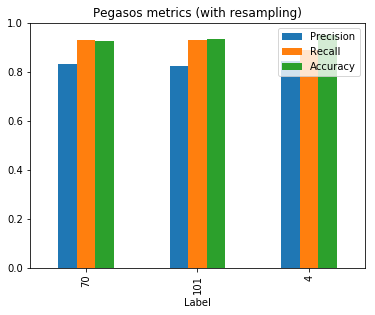

In [34]:
fig = df_metrics_resampled.plot(x='Label', 
                      y=['Precision', 'Recall', 'Accuracy'],
                      kind="bar",
                      title='Pegasos metrics (with resampling)',
                      figsize=(6, 4.5)).get_figure()

fig.savefig("pegasos_all_metrics_upsampled.png")

In [35]:
print("Mean Precision: ", df_metrics_resampled["Precision"].mean())
print("Mean Recall: ", df_metrics_resampled["Recall"].mean())
print("Mean Accuracy: ", df_metrics_resampled["Accuracy"].mean())

Mean Precision:  0.8351308252345885
Mean Recall:  0.917736184467338
Mean Accuracy:  0.9385108330790356


#### Undersampling

These are for the random split where the test set is a third of the dataset, with undersampling.

In [36]:
df_metrics_unders = pd.DataFrame(np.column_stack([highest[1:], TPs_unders, FPs_unders, TNs_unders, FNs_unders, precisions_unders, recalls_unders, accs_unders]),
                  columns=['Label',
                           'True Positive',
                           'False Positive',
                           'True Negative', 
                           'False Negative',
                           'Precision',
                           'Recall',
                           'Accuracy'])

df_metrics_unders = df_metrics_unders.astype({'Label': int,
                                'True Positive': int,
                                'False Positive': int,
                                'True Negative': int,
                                'False Negative': int})
df_metrics_unders

,Label,True Positive,False Positive,True Negative,False Negative,Precision,Recall,Accuracy
0,70,1727,360,4335,132,0.827504,0.928994,0.924931
1,101,1511,371,4575,97,0.802869,0.939677,0.928593
2,4,1041,313,5098,102,0.768833,0.910761,0.936680


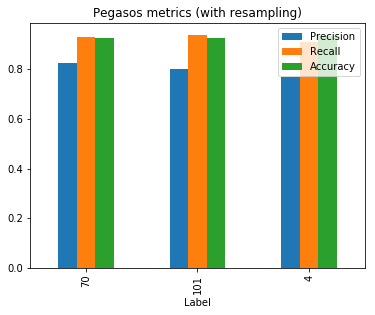

In [37]:
fig = df_metrics_unders.plot(x='Label', 
                      y=['Precision', 'Recall', 'Accuracy'],
                      kind="bar",
                      title='Pegasos metrics (with resampling)',
                      figsize=(6, 4.5)).get_figure()

fig.savefig("pegasos_all_metrics_undersampled.png")

In [38]:
print("Mean Precision: ", df_metrics_unders["Precision"].mean())
print("Mean Recall: ", df_metrics_unders["Recall"].mean())
print("Mean Accuracy: ", df_metrics_unders["Accuracy"].mean())

Mean Precision:  0.799735322938606
Mean Recall:  0.9264772848704341
Mean Accuracy:  0.9300681517648256


#### Best score

These are the results of the `GridSearchCV`

In [39]:
Ts, lmbds, scores = [], [], []

for i in params:
    Ts.append(i[0]['T'])
    lmbds.append(i[0]['lmbd'])
    scores.append(i[1])

df_results = pd.DataFrame(np.column_stack([highest, Ts, lmbds, scores]),
                          columns=['Label', 'Iterations', 'Lambda', 'F1 Test score'])

df_results = df_results.astype({"Label": int, "Iterations": int})
df_results

,Label,Iterations,Lambda,F1 Test score
0,33,19860,0.0001,0.911987
1,70,19860,0.0001,0.916777
2,101,19860,0.0001,0.907211
3,4,19860,0.0001,0.884570


We can see that only the test score changes.

Let's do some plotting

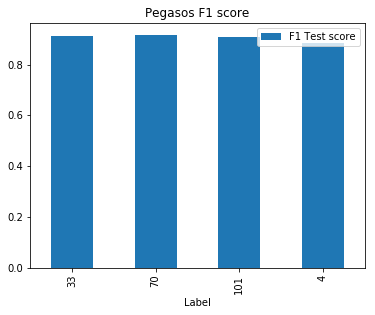

In [40]:
fig = df_results.plot(x='Label', y=['F1 Test score'], kind="bar",
                      title='Pegasos F1 score', figsize=(6, 4.5)).get_figure()

fig.savefig("pegasos_test_scores.png")

if len(df_results['Iterations'].unique()) != 1:
    fig = df_results.plot(x='Label', y=['Iterations'], title='Pegasos iterations',
                          kind="bar", color='g', figsize=(6, 4.5)).get_figure()
    
    fig.savefig("pegasos_iterations.png")
    
if len(df_results['Lambda'].unique()) != 1:
    fig = df_results.plot(x='Label', y=['Lambda'], kind="bar", title='Pegasos lambdas',
                          color='y', figsize=(6, 4.5)).get_figure()
    
    fig.savefig("pegasos_lambda.png")

Our final average F1 test score is:

In [41]:
df_results["F1 Test score"].mean()

0.9051360658613312

## Perceptron

Here's our Perceptron. We'll replicate the same workflow as we did for Pegasos and we'll compare their results.

In [16]:
class Perceptron(BaseEstimator, MyBaseClassifier):
    def __init__(self, T=1):
        self.T = T
    
    def fit(self, X, Y):
        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])
        
        # Repeat for each epoch up to T
        for t in range(self.T):
            
            # For each training example
            for i in range(X.shape[0]-1):
                
                #Compute the output score for this instance.
                score = X[i].dot(self.w.T)

                # If there was an error, update the weights.
                if Y[i]*score <= 0:
                    self.w += Y[i]*X[i]

### Label 1: 33

In [43]:
currentLabel = y1

We split the dataset and run the Perceptron for the first time.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,currentLabel,test_size=0.33,random_state=42,stratify=currentLabel)

In [45]:
classifier = Perceptron()

In [46]:
classifier.fit(X_train, y_train)

In [47]:
classifier.score(X_train, y_train), classifier.score(X_test, y_test)

(0.9345228076081468, 0.8605564089435057)

Our perceptron is clearly suffering from overfitting.

We now check other metrics:

In [48]:
TPs_perceptron, FPs_perceptron, TNs_perceptron, FNs_perceptron = [], [], [], []
precisions_perceptron, recalls_perceptron, accs_perceptron = [], [], []

y_pred = classifier.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
    
TNs_perceptron.append(tn)
TPs_perceptron.append(tp)
FPs_perceptron.append(fp)
FNs_perceptron.append(fn)
precisions_perceptron.append(precision)
recalls_perceptron.append(recall)
accs_perceptron.append(acc)
    
print("True positive: ", tp)
print("False positive: ", fp)
print("FP ratio: ", fp/(tp+fp),"(",np.round(fp/(tp+fp)*100, 2),"%)")
print("True negative: ", tn)
print("False negative: ", fn)
print("FN ratio: ", fn/(tn+fn),"(",np.round(fn/(tn+fn)*100, 2),"%)")
print("Precision: ", precision,"(",np.round(precision*100, 2),"%)")
print("Recall: ", recall,"(",np.round(recall*100, 2),"%)")
print("Accuracy: ", acc,"(",np.round(acc*100, 2),"%)")

True positive:  2521
False positive:  401
FP ratio:  0.13723477070499657 ( 13.72 %)
True negative:  3216
False negative:  416
FN ratio:  0.1145374449339207 ( 11.45 %)
Precision:  0.8627652292950034 ( 86.28 %)
Recall:  0.8583588695948247 ( 85.84 %)
Accuracy:  0.8753433018004272 ( 87.53 %)


We plot the learning curve

In [49]:
sizes = range(1000, 14000, 1000)
train_size, train_score, val_score = learning_curve(Perceptron(), X, currentLabel, train_sizes=sizes, cv=10,
                                                   n_jobs=-1, verbose=10)
val_score

[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.4s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    4.9s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:    8.2s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:   12.1s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:   16.6s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   21.1s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   26.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   30.7s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   35.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   40.2s finished


array([[0.62365591, 0.80645161, 0.8262863 , 0.78139535, 0.82923977,
        0.77031802, 0.81485527, 0.82907268, 0.77870216, 0.80550775],
       [0.81813031, 0.86085544, 0.86203616, 0.84952804, 0.8807543 ,
        0.80816327, 0.84150156, 0.84352431, 0.83958333, 0.84527064],
       [0.86153846, 0.85211655, 0.78764897, 0.73921442, 0.76714101,
        0.76394194, 0.79528024, 0.78864009, 0.75274056, 0.8045977 ],
       [0.8346915 , 0.81362007, 0.84576613, 0.81747457, 0.85061728,
        0.79407407, 0.84049774, 0.84400826, 0.81524249, 0.84241706],
       [0.85934066, 0.85092127, 0.87317073, 0.86023835, 0.89608939,
        0.832315  , 0.871903  , 0.86367969, 0.87539599, 0.86684932],
       [0.82790698, 0.80282519, 0.80487805, 0.83273165, 0.88019266,
        0.80783723, 0.86023959, 0.84806776, 0.82714617, 0.84463107],
       [0.86053077, 0.83642496, 0.86595852, 0.83828775, 0.90086957,
        0.84550562, 0.88791689, 0.86886887, 0.86636971, 0.87413395],
       [0.87119956, 0.86280992, 0.8670520

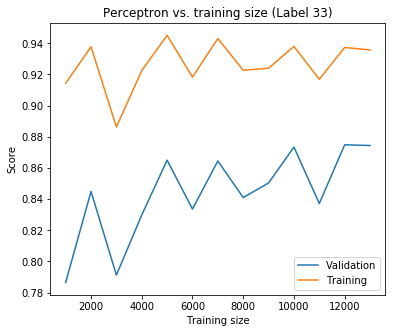

In [50]:
plt.figure(figsize=(6, 5))
plt.title('Perceptron vs. training size (Label 33)')
plt.plot(train_size, np.mean(val_score, 1), label='Validation')
plt.plot(train_size, np.mean(train_score, 1), label='Training')
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Score')

plt.savefig('perceptron_learning_curve_y1.png')
plt.show()

Let's see the validation curve

In [51]:
T = range(1,11)
train_score, val_score = validation_curve(Perceptron(), X, currentLabel, 'T', T, cv=10, verbose=10, n_jobs=-1)
val_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 100 | elapsed:   11.9s remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  13 out of 100 | elapsed:   56.4s remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed:  1.6min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  35 out of 100 | elapsed:  2.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  46 out of 100 | elapsed:  3.0min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  57 out of 100 | elapsed:  3.7min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  68 out of 100 | elapsed:  4.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:  5.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:  5.9min remaining:   39.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished


array([[0.89422028, 0.88324324, 0.90873786, 0.87416481, 0.91925466,
        0.8654105 , 0.9118896 , 0.89029126, 0.89736701, 0.8838008 ],
       [0.8989845 , 0.88381963, 0.91250618, 0.88472459, 0.92573402,
        0.8719346 , 0.91318328, 0.88803089, 0.89685125, 0.90249433],
       [0.89314195, 0.87919106, 0.91144279, 0.88611898, 0.92281304,
        0.87733888, 0.91190603, 0.89936181, 0.88131868, 0.90602138],
       [0.90447922, 0.87919106, 0.91411649, 0.89113356, 0.92562929,
        0.88054608, 0.90987124, 0.89805825, 0.89397975, 0.89624724],
       [0.90287575, 0.88463583, 0.91248771, 0.8836425 , 0.93333333,
        0.87777778, 0.91257996, 0.89985344, 0.89428263, 0.90454545],
       [0.90584416, 0.88197425, 0.91015625, 0.88463703, 0.92914286,
        0.88070893, 0.91483664, 0.89970501, 0.89875474, 0.9068323 ],
       [0.90118153, 0.88142934, 0.91420118, 0.88342857, 0.92795389,
        0.8744884 , 0.91121744, 0.89882122, 0.88767123, 0.90457369],
       [0.90010858, 0.87969516, 0.9129574

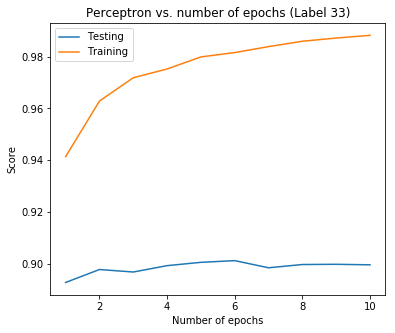

In [52]:
plt.figure(figsize=(6, 5))
plt.title('Perceptron vs. number of epochs (Label 33)')
plt.plot(T, np.mean(val_score, 1), label='Testing')
plt.plot(T, np.mean(train_score, 1), label='Training')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Score')

plt.savefig('perceptron_validation_curve_y1.png')
plt.show()

We now want to check what's the best number of epochs `T`. Therefore, we use `GridSearchCV` to estimate it. Again, we run a 10-fold cross validation.

In [53]:
params_perceptron = []
param_grid = [{'T':range(1,10)}]

svc = Perceptron()
clf = GridSearchCV(svc, param_grid, cv = 10, verbose=10, n_jobs=-1)

clf.fit(X, currentLabel)

params_perceptron.append([clf.best_params_, clf.best_score_])
params_perceptron[0]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  5.2min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.4min finished


[{'T': 6}, 0.9012592157015665]

### Other labels: 70, 101, 4

We now repeat the same workflow for the other labels.
However, here we also upsample data in order to check if it can help the algorithm in the prediction.

In [54]:
lbl_idx = { '2': '70', '3': '101', '4': '4' }
TPs_resampled_perceptr, FPs_resampled_perceptr, TNs_resampled_perceptr, FNs_resampled_perceptr, precisions_resampled_perceptr, recalls_resampled_perceptr, accs_resampled_perceptr = [], [], [], [], [], [], []
TPs_unders_perceptr, FPs_unders_perceptr, TNs_unders_perceptr, FNs_unders_perceptr, precisions_unders_perceptr, recalls_unders_perceptr, accs_unders_perceptr = [], [], [], [], [], [], []

for i in range(2,5):    
    currentLabel = eval('y'+str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(X, currentLabel, test_size=0.33,
                                                        random_state=42, stratify=currentLabel)
    
    classifier = Perceptron()
    classifier.fit(X_train, y_train)
    train_score = classifier.score(X_train, y_train)
    
    y_pred = classifier.predict(X_test)  
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    TNs_perceptron.append(tn)
    TPs_perceptron.append(tp)
    FPs_perceptron.append(fp)
    FNs_perceptron.append(fn)
    precisions_perceptron.append(precision)
    recalls_perceptron.append(recall)
    accs_perceptron.append(acc)
    
    # Up-sample
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    classifier = Perceptron()
    classifier.fit(X_train_resampled, y_train_resampled)
    train_score_resampled = classifier.score(X_train_resampled, y_train_resampled)
    
    y_pred = classifier.predict(X_test)  
    f1_resampled = f1_score(y_test, y_pred)  
    tn_resampled, fp_resampled, fn_resampled, tp_resampled = confusion_matrix(y_test, y_pred).ravel()
    precision_resampled = precision_score(y_test, y_pred)
    recall_resampled = recall_score(y_test, y_pred)
    acc_resampled = accuracy_score(y_test, y_pred)
    
    TNs_resampled_perceptr.append(tn_resampled)
    TPs_resampled_perceptr.append(tp_resampled)
    FPs_resampled_perceptr.append(fp_resampled)
    FNs_resampled_perceptr.append(fn_resampled)
    precisions_resampled_perceptr.append(precision_resampled)
    recalls_resampled_perceptr.append(recall_resampled)
    accs_resampled_perceptr.append(acc_resampled)
    
    # Under-sample
    rus = RandomUnderSampler(random_state=42, replacement=True)
    X_train_unders, y_train_unders = ros.fit_resample(X_train, y_train)
    
    classifier = Perceptron()
    classifier.fit(X_train_unders, y_train_unders)
    train_score_unders = classifier.score(X_train_unders, y_train_unders)
    
    y_pred = classifier.predict(X_test)  
    f1_unders = f1_score(y_test, y_pred)
    tn_unders, fp_unders, fn_unders, tp_unders = confusion_matrix(y_test, y_pred).ravel()
    precision_unders = precision_score(y_test, y_pred)
    recall_unders = recall_score(y_test, y_pred)
    acc_unders = accuracy_score(y_test, y_pred)
    
    TNs_unders_perceptr.append(tn_unders)
    TPs_unders_perceptr.append(tp_unders)
    FPs_unders_perceptr.append(fp_unders)
    FNs_unders_perceptr.append(fn_unders)
    precisions_unders_perceptr.append(precision_unders)
    recalls_unders_perceptr.append(recall_unders)
    accs_unders_perceptr.append(acc_unders)
    
    print("\nLABEL ", lbl_idx.get(str(i)))
    print("==============")
    
    metrics_name = ["True positive", "False positive", "True negative", "False negative", "FP ratio", "FN ratio",
                    "Training score", "Test score", "Precision", "Recall", "Accuracy"]
    nr = [tp,fp,tn,fn,
          str(fp/(tp+fp))+" ("+str(np.round(fp/(tp+fp)*100, 2))+"%)",
          str(fn/(tn+fn))+" ("+str(np.round(fn/(tn+fn)*100, 2))+"%)",
          str(train_score)+" ("+str(np.round(train_score*100, 2))+"%)",
          str(f1)+" ("+str(np.round(f1*100, 2))+"%)",
          str(precision)+" ("+str(np.round(precision*100, 2))+"%)",
          str(recall)+" ("+str(np.round(recall*100, 2))+"%)",
          str(acc)+" ("+str(np.round(acc*100, 2))+"%)"]
    
    ovs = [tp_resampled,fp_resampled, tn_resampled,fn_resampled,
          str(fp_resampled/(tp_resampled+fp_resampled))+" ("+str(np.round(fp_resampled/(tp_resampled+fp_resampled)*100, 2))+"%)",
          str(fn_resampled/(tn_resampled+fn_resampled))+" ("+str(np.round(fn_resampled/(tn_resampled+fn_resampled)*100, 2))+"%)",
          str(train_score_resampled)+" ("+str(np.round(train_score_resampled*100, 2))+"%)",
          str(f1_resampled)+" ("+str(np.round(f1_resampled*100, 2))+"%)",
          str(precision_resampled)+" ("+str(np.round(precision_resampled*100, 2))+"%)",
          str(recall_resampled)+" ("+str(np.round(recall*100, 2))+"%)",
          str(acc_resampled)+" ("+str(np.round(acc_resampled*100, 2))+"%)"]
    
    uds = [tp_unders,fp_unders, tn_unders,fn_unders,
          str(fp_unders/(tp_unders+fp_unders))+" ("+str(np.round(fp_unders/(tp_unders+fp_unders)*100, 2))+"%)",
          str(fn_unders/(tn_unders+fn_unders))+" ("+str(np.round(fn_unders/(tn_unders+fn_unders)*100, 2))+"%)",
          str(train_score_unders)+" ("+str(np.round(train_score_unders*100, 2))+"%)",
          str(f1_unders)+" ("+str(np.round(f1_unders*100, 2))+"%)",
          str(precision_unders)+" ("+str(np.round(precision_unders*100, 2))+"%)",
          str(recall_unders)+" ("+str(np.round(recall*100, 2))+"%)",
          str(acc_unders)+" ("+str(np.round(acc_unders*100, 2))+"%)"]
    
    df1 = pd.DataFrame(np.column_stack([metrics_name, nr, ovs, uds]), columns=["Metric", "Not resampled", "Oversampled", "Undersampled"])
    display(df1)


LABEL  70


,Metric,Not resampled,Oversampled,Undersampled
0,True positive,1675,1825,1825
1,False positive,230,1295,1295
2,True negative,4465,3400,3400
3,False negative,184,34,34
4,FP ratio,0.12073490813648294 (12.07%),0.4150641025641026 (41.51%),0.4150641025641026 (41.51%)
5,FN ratio,0.039578403957840395 (3.96%),0.009900990099009901 (0.99%),0.009900990099009901 (0.99%)
6,Training score,0.949758580190526 (94.98%),0.8978284422252579 (89.78%),0.8978284422252579 (89.78%)
7,Test score,0.8900106269925611 (89.0%),0.7330789315123519 (73.31%),0.7330789315123519 (73.31%)
8,Precision,0.8792650918635171 (87.93%),0.5849358974358975 (58.49%),0.5849358974358975 (58.49%)
9,Recall,0.9010220548682087 (90.1%),0.9817105970952125 (90.1%),0.9817105970952125 (90.1%)



LABEL  101


,Metric,Not resampled,Oversampled,Undersampled
0,True positive,1355,1580,1580
1,False positive,167,1060,1060
2,True negative,4779,3886,3886
3,False negative,253,28,28
4,FP ratio,0.10972404730617609 (10.97%),0.4015151515151515 (40.15%),0.4015151515151515 (40.15%)
5,FN ratio,0.05027821939586646 (5.03%),0.007153806847215125 (0.72%),0.007153806847215125 (0.72%)
6,Training score,0.9373542670604694 (93.74%),0.9190351961188155 (91.9%),0.9190351961188155 (91.9%)
7,Test score,0.865814696485623 (86.58%),0.7438794726930321 (74.39%),0.7438794726930321 (74.39%)
8,Precision,0.8902759526938239 (89.03%),0.5984848484848485 (59.85%),0.5984848484848485 (59.85%)
9,Recall,0.8426616915422885 (84.27%),0.9825870646766169 (84.27%),0.9825870646766169 (84.27%)



LABEL  4


,Metric,Not resampled,Oversampled,Undersampled
0,True positive,966,1117,1117
1,False positive,181,1099,1099
2,True negative,5230,4312,4312
3,False negative,177,26,26
4,FP ratio,0.15780296425457715 (15.78%),0.49593862815884476 (49.59%),0.49593862815884476 (49.59%)
5,FN ratio,0.03273534307379323 (3.27%),0.00599354541263255 (0.6%),0.00599354541263255 (0.6%)
6,Training score,0.9219978746014877 (92.2%),0.9175124253435242 (91.75%),0.9175124253435242 (91.75%)
7,Test score,0.8436681222707424 (84.37%),0.6650788925275379 (66.51%),0.6650788925275379 (66.51%)
8,Precision,0.8421970357454228 (84.22%),0.5040613718411552 (50.41%),0.5040613718411552 (50.41%)
9,Recall,0.8451443569553806 (84.51%),0.9772528433945756 (84.51%),0.9772528433945756 (84.51%)


Let's now see the Learning curve

[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.3s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    4.5s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:    7.9s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:   11.4s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:   16.1s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   20.3s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   24.8s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   28.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   33.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   37.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.8s remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    6.2s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:   10.2s remaining:   30.1s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:   14.5s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:   19.0s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   23.0s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   27.6s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   31.8s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   36.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   40.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000]


[Parallel(n_jobs=-1)]: Done   5 out of 130 | elapsed:    1.8s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done  19 out of 130 | elapsed:    6.1s remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  33 out of 130 | elapsed:   10.4s remaining:   30.7s
[Parallel(n_jobs=-1)]: Done  47 out of 130 | elapsed:   14.8s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  61 out of 130 | elapsed:   19.8s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  75 out of 130 | elapsed:   24.0s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  89 out of 130 | elapsed:   28.6s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done 103 out of 130 | elapsed:   32.9s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done 117 out of 130 | elapsed:   37.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   41.6s finished


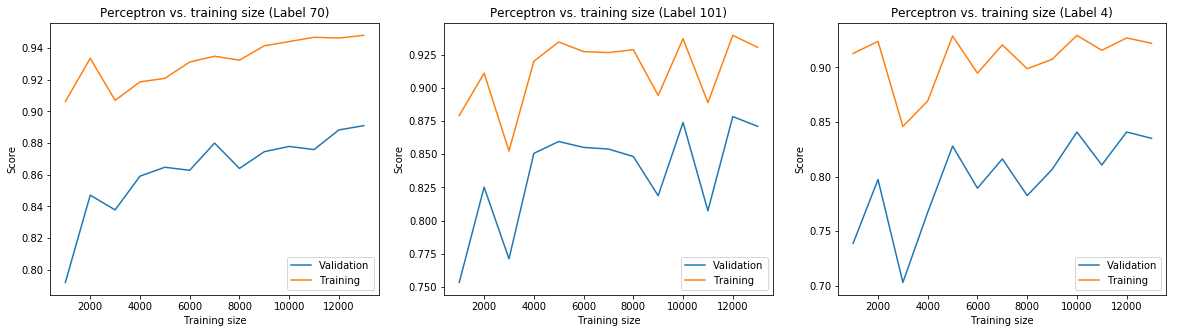

In [55]:
plt.figure(figsize=(20, 5))

for i in range(2,5):
    currentLabel = eval('y'+str(i))
    
    sizes = range(1000, 14000, 1000)
    train_size, train_score, val_score = learning_curve(Perceptron(), X, currentLabel, train_sizes=sizes, cv=10,
                                                   n_jobs=-1, verbose=10)
    
    plt.subplot(1, 3, i-1)
    plt.title('Perceptron vs. training size (Label ' + lbl_idx.get(str(i)) + ')')
    plt.plot(train_size, np.mean(val_score, 1), label='Validation')
    plt.plot(train_size, np.mean(train_score, 1), label='Training')
    plt.legend()
    plt.xlabel('Training size')
    plt.ylabel('Score')

plt.savefig('perceptron_learning_curve_other.png')
plt.show()

We now plot the _validation curve_ and we run `GridSearchCV` to get the best number of epochs for the Perceptron for every label.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 100 | elapsed:    8.4s remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  13 out of 100 | elapsed:   49.2s remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed:  1.5min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  35 out of 100 | elapsed:  2.2min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  46 out of 100 | elapsed:  2.8min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  57 out of 100 | elapsed:  3.4min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  68 out of 100 | elapsed:  4.1min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:  4.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:  5.5min remaining:   36.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.0min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 100 | elapsed:   11.5s remaining:  9.4min
[Parallel(n_jobs=-1)]: Done  13 out of 100 | elapsed:   53.9s remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.0min remaining:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 100 | elapsed:   11.2s remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  13 out of 100 | elapsed:   52.7s remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.9min remaining:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished


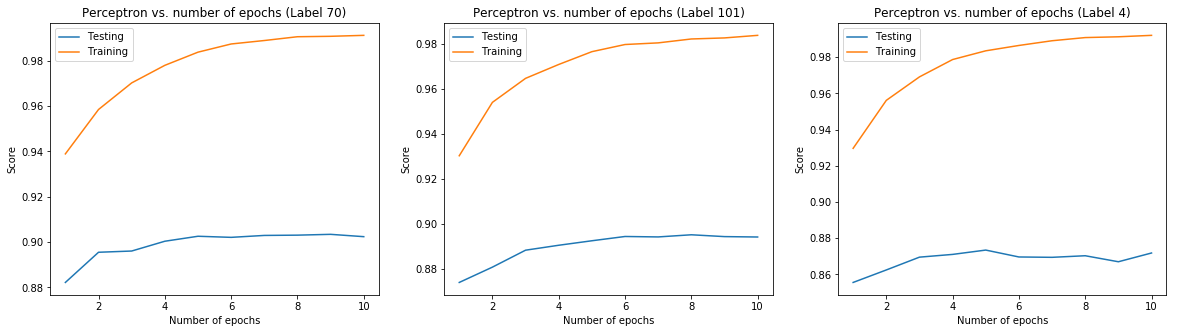

In [56]:
plt.figure(figsize=(20, 5))

for i in range(2,5):
    currentLabel = eval('y'+str(i))
    
    T = range(1,11,1)
    train_score, val_score = validation_curve(Perceptron(), X, currentLabel, 'T', T, cv=10, verbose=10, n_jobs=-1)
    
    param_grid = [{'T': T}]

    svc = Perceptron()
    clf = GridSearchCV(svc, param_grid, cv = 10, verbose=10, n_jobs=-1)

    clf.fit(X, currentLabel)

    params_perceptron.append([clf.best_params_, clf.best_score_])
    params_perceptron[i-1]
    
    plt.subplot(1, 3, i-1)
    plt.title('Perceptron vs. number of epochs (Label ' + lbl_idx.get(str(i)) + ')')
    plt.plot(T, np.mean(val_score, 1), label='Testing')
    plt.plot(T, np.mean(train_score, 1), label='Training')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Score')

plt.savefig('perceptron_validation_curve_other.png')
plt.show()

### Results: Perceptron

We now analyze the results

#### No resampling

These are the results for the random split where the test set is a third of the dataset, without resampling

In [57]:
df_metrics_perceptron = pd.DataFrame(np.column_stack([highest, TPs_perceptron, FPs_perceptron,
                                                      TNs_perceptron, FNs_perceptron, precisions_perceptron,
                                                      recalls_perceptron, accs_perceptron]),
                                     columns=['Label', 'True Positive', 'False Positive', 'True Negative',
                                              'False Negative', 'Precision', 'Recall', 'Accuracy'])

df_metrics_perceptron = df_metrics_perceptron.astype({'Label': int, 'True Positive': int,
                                                      'False Positive': int, 'True Negative': int,
                                                      'False Negative': int})

df_metrics_perceptron

,Label,True Positive,False Positive,True Negative,False Negative,Precision,Recall,Accuracy
0,33,2521,401,3216,416,0.862765,0.858359,0.875343
1,70,1675,230,4465,184,0.879265,0.901022,0.936832
2,101,1355,167,4779,253,0.890276,0.842662,0.935917
3,4,966,181,5230,177,0.842197,0.845144,0.945377


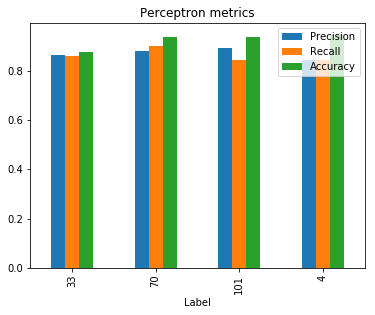

In [58]:
fig = df_metrics_perceptron.plot(x='Label', y=['Precision', 'Recall', 'Accuracy'], kind="bar",
                                 title='Perceptron metrics', figsize=(6, 4.5)).get_figure()

fig.savefig("perceptron_all_metrics.png")

In [59]:
print("Mean Precision: ", df_metrics_perceptron["Precision"].mean())
print("Mean Recall: ", df_metrics_perceptron["Recall"].mean())
print("Mean Accuracy: ", df_metrics_perceptron["Accuracy"].mean())

Mean Precision:  0.8686258273994417
Mean Recall:  0.8617967432401756
Mean Accuracy:  0.9233674092157461


#### Upsampling

These are the results for the random split where the test set is a third of the dataset, with upsampling.

In [60]:
df_metrics_perceptron_resampl = pd.DataFrame(np.column_stack([highest[1:], TPs_resampled_perceptr, FPs_resampled_perceptr,
                                                      TNs_resampled_perceptr, FNs_resampled_perceptr, precisions_resampled_perceptr,
                                                      recalls_resampled_perceptr, accs_resampled_perceptr]),
                                     columns=['Label', 'True Positive', 'False Positive', 'True Negative',
                                              'False Negative', 'Precision', 'Recall', 'Accuracy'])

df_metrics_perceptron_resampl = df_metrics_perceptron_resampl.astype({'Label': int, 'True Positive': int,
                                                      'False Positive': int, 'True Negative': int,
                                                      'False Negative': int})

df_metrics_perceptron_resampl

,Label,True Positive,False Positive,True Negative,False Negative,Precision,Recall,Accuracy
0,70,1825,1295,3400,34,0.584936,0.981711,0.797223
1,101,1580,1060,3886,28,0.598485,0.982587,0.833995
2,4,1117,1099,4312,26,0.504061,0.977253,0.828349


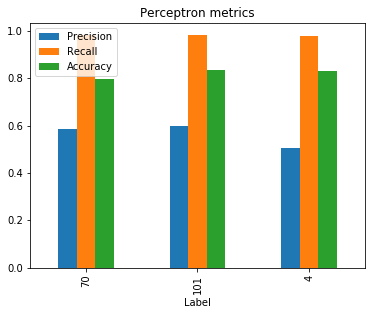

In [61]:
fig = df_metrics_perceptron_resampl.plot(x='Label', y=['Precision', 'Recall', 'Accuracy'], kind="bar",
                                 title='Perceptron metrics', figsize=(6, 4.5)).get_figure()

fig.savefig("perceptron_all_metrics_upsample.png")

In [62]:
print("Mean Precision: ", df_metrics_perceptron_resampl["Precision"].mean())
print("Mean Recall: ", df_metrics_perceptron_resampl["Recall"].mean())
print("Mean Accuracy: ", df_metrics_perceptron_resampl["Accuracy"].mean())

Mean Precision:  0.5624940392539671
Mean Recall:  0.9805168350554684
Mean Accuracy:  0.8198555589461907


#### Undersampling

These are the results for the random split where the test set is a third of the dataset, with upsampling.

In [63]:
df_metrics_perceptron_unders = pd.DataFrame(np.column_stack([highest[1:], TPs_unders_perceptr, FPs_unders_perceptr,
                                                      TNs_unders_perceptr, FNs_unders_perceptr, precisions_unders_perceptr,
                                                      recalls_unders_perceptr, accs_unders_perceptr]),
                                     columns=['Label', 'True Positive', 'False Positive', 'True Negative',
                                              'False Negative', 'Precision', 'Recall', 'Accuracy'])

df_metrics_perceptron_unders = df_metrics_perceptron_unders.astype({'Label': int, 'True Positive': int,
                                                      'False Positive': int, 'True Negative': int,
                                                      'False Negative': int})

df_metrics_perceptron_unders

,Label,True Positive,False Positive,True Negative,False Negative,Precision,Recall,Accuracy
0,70,1825,1295,3400,34,0.584936,0.981711,0.797223
1,101,1580,1060,3886,28,0.598485,0.982587,0.833995
2,4,1117,1099,4312,26,0.504061,0.977253,0.828349


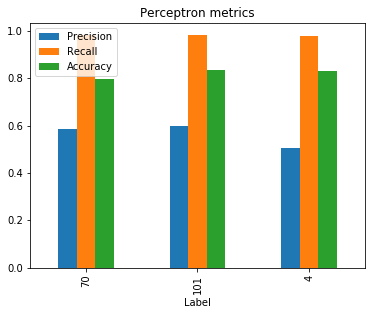

In [64]:
fig = df_metrics_perceptron_resampl.plot(x='Label', y=['Precision', 'Recall', 'Accuracy'], kind="bar",
                                 title='Perceptron metrics', figsize=(6, 4.5)).get_figure()

fig.savefig("perceptron_all_metrics_resampled.png")

In [65]:
print("Mean Precision: ", df_metrics_perceptron_resampl["Precision"].mean())
print("Mean Recall: ", df_metrics_perceptron_resampl["Recall"].mean())
print("Mean Accuracy: ", df_metrics_perceptron_resampl["Accuracy"].mean())

Mean Precision:  0.5624940392539671
Mean Recall:  0.9805168350554684
Mean Accuracy:  0.8198555589461907


#### Best score

These are the results of the `GridSearchCV`

In [66]:
Ts_perceptron, scores_perceptron = [], []

for i in params_perceptron:
    Ts_perceptron.append(i[0]['T'])
    scores_perceptron.append(i[1])

df_results_perceptron = pd.DataFrame(np.column_stack([highest, Ts_perceptron, scores_perceptron]),
                                     columns=['Label', 'Epochs', 'F1 Test score'])

df_results_perceptron = df_results_perceptron.astype({"Label": int, "Epochs": int})
df_results_perceptron

,Label,Epochs,F1 Test score
0,33,6,0.901259
1,70,9,0.903416
2,101,8,0.895035
3,4,5,0.873443


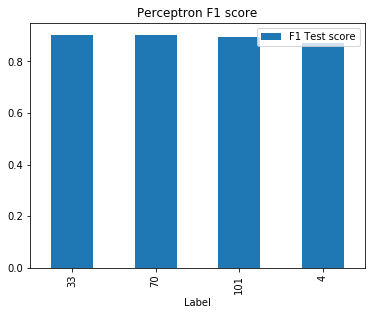

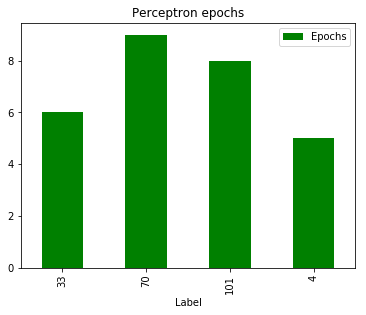

In [67]:
fig = df_results_perceptron.plot(x='Label', y=['F1 Test score'], title='Perceptron F1 score',
                                 kind="bar", figsize=(6, 4.5)).get_figure()

fig.savefig("perceptron_test_scores.png")

if len(df_results_perceptron['Epochs'].unique()) != 1:
    fig = df_results_perceptron.plot(x='Label', y=['Epochs'], title='Perceptron epochs',
                                     kind="bar", color='g', figsize=(6, 4.5)).get_figure()
    
    fig.savefig("perceptron_epochs.png")

Our final average F1 test score is:

In [68]:
df_results_perceptron["F1 Test score"].mean()

0.8932882749610566

## Comparison: Pegasos vs. Perceptron

We can now run both algorithms with the best value for their parameters, on the same split, and compare their performances and execution times

For Pegasos, we now set: `lmbd=0.0001` and `T=19860`. For the Perceptron, we average the number of epochs, so we set `T=7`.

In [69]:
lblidx = { '1':'33', '2': '70', '3': '101', '4': '4' }
avg_pegasos,avg_train_pegasos,train_time_pegasos,pred_time_pegasos=[],[],[],[]
for i in range(1,5):
    print("Training on label",lblidx.get(str(i)))
    currentLabel = eval('y'+str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(X, currentLabel, test_size=0.33,
                                                        random_state=42, stratify=currentLabel)
    
    classifier = Pegasos(lmbd=0.0001,T=19860)
    
    start_time_train = timeit.default_timer()
    classifier.fit(X_train, y_train)
    elapsed_train = timeit.default_timer() - start_time_train
    avg_train_pegasos.append(classifier.score(X_train, y_train))
    
    start_time_test = timeit.default_timer()
    test_score = classifier.score(X_test, y_test)
    elapsed_test = timeit.default_timer() - start_time_test
    
    avg_pegasos.append(test_score)
    train_time_pegasos.append(elapsed_train)
    pred_time_pegasos.append(elapsed_test)
    
df_pegasos=pd.DataFrame(np.column_stack([highest, avg_train_pegasos, avg_pegasos, train_time_pegasos, pred_time_pegasos]),
                    columns=["Label", "Training score", "Test score", "Training time", "Test time"])
df_pegasos = df_pegasos.astype({"Label": int})
df_pegasos

Training on label 33
Training on label 70
Training on label 101
Training on label 4


,Label,Training score,Test score,Training time,Test time
0,33,0.954629,0.914847,4.209161,0.038344
1,70,0.960900,0.921089,3.822495,0.038160
2,101,0.952308,0.911535,4.120745,0.037800
3,4,0.940500,0.887369,4.030551,0.037777


In [70]:
lblidx = { '1':'33', '2': '70', '3': '101', '4': '4' }
avg_perc,avg_train_perc,train_time_perc,pred_time_perc=[],[],[],[]
for i in range(1,5):
    print("Training on label",lblidx.get(str(i)))
    currentLabel = eval('y'+str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(X, currentLabel, test_size=0.33,
                                                        random_state=42, stratify=currentLabel)
    
    classifier = Perceptron(T=7)
    
    start_time_train = timeit.default_timer()
    classifier.fit(X_train, y_train)
    elapsed_train = timeit.default_timer() - start_time_train
    avg_train_perc.append(classifier.score(X_train, y_train))
    
    start_time_test = timeit.default_timer()
    test_score = classifier.score(X_test, y_test)
    elapsed_test = timeit.default_timer() - start_time_test
    
    avg_perc.append(test_score)
    train_time_perc.append(elapsed_train)
    pred_time_perc.append(elapsed_test)
    
df_perc=pd.DataFrame(np.column_stack([highest, avg_train_perc, avg_perc, train_time_perc, pred_time_perc]),
                    columns=["Label", "Training score", "Test score", "Training time", "Test time"])
df_perc = df_perc.astype({"Label": int})
df_perc

Training on label 33
Training on label 70
Training on label 101
Training on label 4


,Label,Training score,Test score,Training time,Test time
0,33,0.990695,0.897238,9.792032,0.037281
1,70,0.991919,0.910322,9.934725,0.038611
2,101,0.981542,0.886895,9.991619,0.035273
3,4,0.994836,0.873177,9.132115,0.033235


In [71]:
train_mean=[str(np.round(df_pegasos['Training score'].mean()*100,2))+"%", str(np.round(df_perc['Training score'].mean()*100,2))+"%"]
test_mean=[str(np.round(df_pegasos['Test score'].mean()*100,2))+"%", str(np.round(df_perc['Test score'].mean()*100,2))+"%"]
train_time_mean=[str(np.round(df_pegasos['Training time'].mean(),2))+"s", str(np.round(df_perc['Training time'].mean(),2))+"s"]
test_time_mean=[str(np.round(df_pegasos['Test time'].mean(),2))+"s", str(np.round(df_perc['Test time'].mean(),2))+"s"]

df_comp = pd.DataFrame(np.column_stack([["Pegasos","Perceptron"],train_mean,test_mean,train_time_mean,test_time_mean]),
                      columns=["Algorithm", "Training score", "Test score", "Training time", "Test time"])
df_comp

,Algorithm,Training score,Test score,Training time,Test time
0,Pegasos,95.21%,90.87%,4.05s,0.04s
1,Perceptron,98.97%,89.19%,9.71s,0.04s


Finally, we can use CV to estimate the risk in order to to evaluate performance of our algorithms.

In [24]:
lblidx = { '1':'33', '2': '70', '3': '101', '4': '4' }
avg_pegasos,train_time_pegasos=[],[]
for i in range(1,5):
    print("Training on label",lblidx.get(str(i)))
    currentLabel = eval('y'+str(i))
    
    classifier = Pegasos(lmbd=0.0001,T=19860)   
    
    start_time_train = timeit.default_timer()
    scores = cross_val_score(classifier, X, currentLabel, cv=10, n_jobs=-1)
    elapsed_time = timeit.default_timer() - start_time_train
    avg_pegasos.append(scores.mean())
    train_time_pegasos.append(elapsed_time)
    
df_pegasos=pd.DataFrame(np.column_stack([highest, avg_pegasos, train_time_pegasos]),
                    columns=["Label", "Score", "CV time"])
df_pegasos = df_pegasos.astype({"Label": int})
df_pegasos

Training on label 33
Training on label 70
Training on label 101
Training on label 4


,Label,Score,CV time
0,33,0.913814,32.621747
1,70,0.917984,22.754393
2,101,0.907101,23.060167
3,4,0.883928,23.336162


In [21]:
lblidx = { '1':'33', '2': '70', '3': '101', '4': '4' }
avg_perc,avg_train_perc,train_time_perc,pred_time_perc=[],[],[],[]
for i in range(1,5):
    print("Training on label",lblidx.get(str(i)))
    currentLabel = eval('y'+str(i))
    
    classifier = Perceptron(T=7)
    
    start_time_train = timeit.default_timer()
    scores = cross_val_score(classifier, X, currentLabel, cv=10, n_jobs=-1)
    elapsed_time = timeit.default_timer() - start_time_train
    avg_perc.append(scores.mean())
    train_time_perc.append(elapsed_time)
    
df_perc=pd.DataFrame(np.column_stack([highest, avg_perc, train_time_perc]),
                    columns=["Label", "Score", "CV time"])
df_perc = df_perc.astype({"Label": int})
df_perc

Training on label 33
Training on label 70
Training on label 101
Training on label 4


,Label,Score,CV time
0,33,0.898497,124.642592
1,70,0.902933,120.251307
2,101,0.894081,119.448373
3,4,0.869438,117.703586


In [25]:
score_mean=[str(np.round(df_pegasos['Score'].mean()*100,2))+"%", str(np.round(df_perc['Score'].mean()*100,2))+"%"]
time_mean=[str(np.round(df_pegasos['CV time'].mean(),2))+"s", str(np.round(df_perc['CV time'].mean(),2))+"s"]

df_comp = pd.DataFrame(np.column_stack([["Pegasos","Perceptron"],score_mean,time_mean]),
                      columns=["Algorithm", "Score", "CV time"])
df_comp

,Algorithm,Score,CV time
0,Pegasos,90.57%,25.44s
1,Perceptron,89.12%,120.51s
